# Import Data:

In [1]:
#list the data - the csv files in this directory are a result of the API code below
!ls Data

1997_senatevote_meta.csv  2009_senatevote_meta.csv
1998_housevote_meta.csv   2009_senatevote_pos.csv
1998_housevote_pos.csv	  2010_housevote_meta.csv
1998_senatevote_meta.csv  2010_housevote_pos.csv
1998_senatevote_pos.csv   2010_senatevote_meta.csv
1999_housevote_meta.csv   2010_senatevote_pos.csv
1999_housevote_pos.csv	  2011_housevote_meta.csv
1999_senatevote_meta.csv  2011_housevote_pos.csv
1999_senatevote_pos.csv   2011_senatevote_meta.csv
2000_housevote_meta.csv   2011_senatevote_pos.csv
2000_housevote_pos.csv	  2012_housevote_meta.csv
2000_senatevote_meta.csv  2012_housevote_pos.csv
2000_senatevote_pos.csv   2012_senatevote_meta.csv
2001_housevote_meta.csv   2012_senatevote_pos.csv
2001_housevote_pos.csv	  2013_housevote_meta.csv
2001_senatevote_meta.csv  2013_housevote_pos.csv
2001_senatevote_pos.csv   2013_senatevote_meta.csv
2002_housevote_meta.csv   2013_senatevote_pos.csv
2002_housevote_pos.csv	  2014_housevote_meta.csv
2002_senatevote_meta.csv  2014_housevote_pos.csv
2002_

In [2]:
!ls

Capstone Project Proposal - 2.pdf  images
Data				   PROPUBLICA_API_KEY.TXT
Exploratory Data Analysis.ipynb    README.md


### Get Pro Publica API working

In [3]:
import requests

#Load ProPublica API key without exposing it to github. Request one yourself. They're free.
#https://projects.propublica.org/api-docs/congress-api/
APIfile = open('./PROPUBLICA_API_KEY.TXT',)
APIkey = APIfile.read().replace('\n', '')

#simple unit tests - will throw an error if API key is malformed
assert type(APIkey) == str
assert len(APIkey) == 40

#create API key header
headers = {'X-API-Key': APIkey}

#API request function
def API_Request(end_point, verbose=True):
    '''for a given endpoint, return API response from Propublica api as a dictionary'''
    
    #send request using combined url, endpoint, and headers
    response = requests.get(url+end_point, headers=headers)
    
    #raise error if status code isn't 200. 
    response.raise_for_status()
    
    #return json response interpreted as a dictionary. 
    return response.json()

#load base url and test endpoint
url = 'https://api.propublica.org/congress/v1'
test_endpoint = '/members/new.json'

#test that the API is working. Prints 'OK' on succes
new_members = API_Request(test_endpoint)
assert new_members['status'] == 'OK'
assert new_members['results'][0]['num_results'] == '20'
print(new_members['status'])

OK


### OK, The API is working.  Let's import voting data

In [4]:
import pandas as pd
import numpy as np
from retrying import retry
from datetime import datetime
import sys


@retry(stop_max_attempt_number=5) #we're going to try this function 5 times until it returns a value
def API_attempts(endpoint):
    '''takes and endpoint and requests the API with it for a given number of times'''  
    #if we can't extract the status we'll keep trying, and if it's OK return the repsonse
    
    #initialize status as an error, this will change if we can extract it.
    status = 'Error fetching API response'
    
    #try to get the API response and extract status without throwing an error on failure
    try:
        #send endpoint to API function for request
        response = API_Request(endpoint)
        
        #extract the status of the API request
        status = response['status']   
    except:
        pass
    
    #if the status is not OK:
    if status != 'OK':
        #Say what the status is
        print(status, end=' ')
        
        #state that we're retrying
        print('retrying')
        
        raise
    else: 
        #return the response if status is ok
        return response
    
        
#let's create a function that will import vote positions for a given rollcall vote.
def import_vote(congress, chamber, session, roll_call):
    '''imports vote details and member positions of a given roll_call vote
        takes congress number 102-116 for House, 80-116 for Senate
        chamber(house|senate) session 1 for odd 2 for even-numbered years
        returns a dictionary of vote positions and API status'''
    #construct endpoint for API request
    for x in [congress, chamber, session, roll_call]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/sessions/{}/votes/{}.json'.format(congress, chamber.lower(), session, roll_call)
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return the vote positions
    try:
        vote = call_response['results']['votes']['vote']
        return vote
    except:
        return {}
    
def import_members(congress, chamber):
    '''imports memberdetails for a given congress and chamber
    https://projects.propublica.org/api-docs/congress-api/members/#lists-of-members'''
    
    #construct endpoint for API request
    for x in [congress, chamber]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/members.json'.format(congress, chamber.lower())
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return robustly
    try:
        members = call_response['results'][0]['members']
        return members
    except:
        return {}

def get_member(member_id):
    '''gets info on a specific member by member id
    https://projects.propublica.org/api-docs/congress-api/members/#get-a-specific-member'''
    #construct API endpoint
    call_endpoint = '/members/{}.json'.format(member_id)
    
    #request API endpoint - retry a few times if needed
    call_response = API_attempts(call_endpoint)
    
       #try to extract results and return robustly
    try:
        member = call_response['results'][0]
        return member
    except:
        return {}
    
    
def positions_df(metalist):
    '''return a dataframe of postions for a given list of vote metadata'''
    
    #initialize dataframe
    dfp = pd.DataFrame()
    
    #for every position in the list
    for congress, chamber, session, roll_call in metalist:
        
        #request the roll_call vote from the API
        vote = import_vote(congress, chamber, session, roll_call)
        
        #extract the positions from the rollcall vote data
        positions = vote.pop('positions')
        
        #turn the postions into a dataframe
        call_positions = pd.DataFrame(positions)
        
        #if both dataframes we are going to merge are not empty
        if not dfp.empty and not call_positions.empty:
            
            #handle duplicated positions for malformed returns
            dups = call_positions.duplicated()
            dups = dups.sum()
            if dups > 0: 
                call_postions = call_postions.drop_duplicates()
                print('dropped{}duplicates'.format(dups))
        
            #MERGE THE POSITIONS FOR A GIVEN ROLL CALL VOTE INTO DATAFRAME <- core of function 
            dfp = pd.merge(dfp, call_positions, on=mergelst, how='outer')
            
            #let us know it's working
            print('.', end='')
            
        #If dfp is empty this is the first run and we need to initialize it
        elif dfp.empty: 
            #make it equal to call_positions
            dfp = call_positions
            
            #make a list of the columns that will be used to merge the call positions
            mergelst = dfp.columns.tolist()[:-1]
            
            #move party and state to front of merglist
            for x in ['state','party']:
                mergelst.insert(0, mergelst.pop(mergelst.index(x)))
            
            #alert that we've started
            print('\ndf created on', congress, chamber, session, roll_call, end=' ')
        
        #handle empty postitions dataframe:
        elif call_positions.empty:
            
            #let us know there was a problem
            print('\nno vote postions available for', congress, chamber, session, roll_call, end=' ')
            
            #append a series of Nan values
            ht = dfp.shape[0]
            nans = pd.Series([np.nan for _ in range(ht)])
            print ('dfp.shape:', dfp.shape)
            print ('Appending {} NaNs'.format(len(nans)))
            dfp = pd.concat([dfp, nans], axis = 1)
            print(dfp.iloc[:3,-4:])
        
        #handle unknown issue
        else:
            print('\nunknown error for', congress, chamber, session, roll_call, end=' ')
    
    #create a multindex of partymembers
    dfp = dfp.set_index(mergelst).transpose()
    
    #after transposing use the metalist as the index
    dfp.index = metalist
    
    #return the complete data frame
    return dfp 

def import_month(year, chamber, month):
    '''import vote metadata for a given year or month and return a dataframe '''
    
    #Stop everthing if we are using a year before 1989 or after now
    assert 1989 <= year <= int(datetime.now().year), "year out of range"
    
    #construct endpoint
    call_endpoint = '/{}/votes/{}/{}.json'.format(chamber.lower(), str(year), str(month))
    
    #use endpoint to request the API robustly with attempts function
    response = API_attempts(call_endpoint)
    
    #Extract the votes from the response
    votes = response['results']['votes']

    #create a dataframe out of the votes
    votesdf = pd.DataFrame(votes)
    
    if not votesdf.empty:
        votesdf = votesdf.set_index(['congress','chamber','session','roll_call']).sort_index()
    
    #return the months dataframe
    return votesdf

def import_year(year, chamber):
    '''import votes based on dates, return a dataframe of appended votes'''
    
    
    #So we know we started:
    print('importing', chamber, year, end=' ')
    #loop through the months 
    for month in range(1,13):
        
        #import the first month
        if month == 1:
            yeardf = import_month(year, chamber, month)
       
        #import the month of votes as a df and append it to the list 
        else:
            df = import_month(year, chamber, month)
            if not df.empty:
                yeardf = yeardf.append(df)
            else:
                print('skip', end=' ')
        #print something so we know it's working
        print(month, end=' ')
        
    #return the dataframe
    return yeardf

def save_years(start_y, end_y):
    '''take a range of years and save a series of dataframes for those years in both the hosue and senate'''
    #iterate through the range of years
    for year in range(start_y, end_y+1):
        #alternate between senate and house
        for chamber in ['senate','house']:
            
            #construct paths
            metapath, pospath = construct_paths(year, chamber)
            
            #import vote metadata dataframe
            votemetadf = import_year(year, chamber)
            
            #import vote positions for given dataframe
            voteposdf = positions_df(votemetadf.index)
            
            #save them
            save_csv(year, chamber, votemetadf, metapath)
            save_csv(year, chamber, voteposdf, pospath)
            
def save_csv(year, chamber, df, path):
    '''takes dataframes from a given year and chamber and saves them to given paths'''
    #announce what we're doing
    print('\nsaving {} {} as {}'.format(str(year), chamber, path))
        
    #save data frames as csv in data/csv directory
    df.to_csv(path)
    
def construct_paths(year, chamber):
    '''construct paths to save or load csv files, 
    takes year and chamber and returns meta path and position path'''
    pathhead = 'Data/{}_{}vote_'.format(str(year), chamber)
    metapath = pathhead + 'meta.csv'
    pospath = pathhead + 'pos.csv'
    return metapath, pospath
                    
def load_cache(year, chamber):
    '''try to load data for a given year and chamber from csv, and use the API to cache it if it's missing'''
    #construct paths
    metapath, pospath = construct_paths(year, chamber.lower())
    
    #setup header / index col
    header = list(range(5))
    if chamber.lower() == 'house':
        header.append(5)
    index_col = list(range(4))
    
    #try to import to load the dfs via csv, and if they don't exist import via the API and cache them.
    try:
        votemetadf = pd.read_csv(metapath, index_col=index_col)
        
        #check if too many days have passed
        if year == int(datetime.now().year):
            assert (datetime.now() - pd.to_datetime(votemetadf.date)[-1]).days < 7, 'Cache out of date'            
    
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        votemetadf = import_year(year, chamber)
        save_csv(year, chamber, votemetadf, metapath)
        
    try:
        voteposdf = pd.read_csv(pospath, header=header, index_col=index_col)
        #check indexes of postions and metadata or the same length
        assert len(voteposdf.index) == len(votemetadf.index), 'dataframe index mismatch'
        
    except (FileNotFoundError, AssertionError) as e:
        print(e, 'importing from API')
        voteposdf = positions_df(votemetadf.index)
        save_csv(year, chamber, voteposdf, pospath)
    
    #convert dw_nominate into float64 so it sorts correctly
    floatcol = voteposdf.columns.levels[-3].astype(float).tolist()
    newcolumns = voteposdf.columns.set_levels(floatcol, level='dw_nominate')
    voteposdf.columns = newcolumns
    
    return votemetadf, voteposdf
   
#def check_df(df)
#    '''check the df for problems and raise an exception if they are found'''
#    if int(datetime.now().year) == 
    
#testmetahouse.head()
#tests - comment out when working

#senate_month_test = import_month(2019, 'senate', 1)
#senate_month_test

#senate_2019_test = import_year(2019, 'senate')
#senate_2019_test

#positions = positions_df(senate_2019_test.index)
#positions

#save_years(2019, 2019)

#testmetasenate, test_dfsenate = load_csv(2019, 'Senate')

#members = import_members(115, 'senate')
#print(len(members))

#member = get_member('W000817')
#print(member['first_name'], member['last_name'])

# Explore Data:

## Sort by political spectrum
Political scientists have already provided a metric for political ideology using dimension reduction called [dw_nominate](https://voteview.com/about). In the 1st dimension, scores closer to 1 indicate conservative voting behavior while scores closer to -1 indicate liberal voting behavior. Sorting by this indicator easily distinguishes parties from one another in the multi-index of house members.

In [5]:
from tabulate import tabulate
testmetasenate, test_dfsenate = load_cache(2019, 'Senate')
test_dfsenate.sort_index('columns', level='dw_nominate', inplace=True)
test_dfsenate.head()
#print(tabulate(testmetasenate[:1], tablefmt='github', showindex=True, headers='keys')) #for markdown

party                                             D                            \
state                                            MA            CA          NJ   
dw_nominate                                  -0.767        -0.696      -0.620   
member_id                                   W000817       H001075     B001288   
name                               Elizabeth Warren Kamala Harris Cory Booker   
congress chamber session roll_call                                              
116      Senate  1       1                       No            No          No   
                         2                       No            No          No   
                         3                       No            No          No   
                         4                       No            No          No   
                         5                      Yes           Yes         Yes   

party                                           ID             D  \
state                                           VT            WI   
dw_nominate                                 -0.524        -0.518   
member_id                                  S000033       B001230   
name                               Bernard Sanders Tammy Baldwin   
congress chamber session roll_call                                 
116      Senate  1       1                      No            No   
                         2                      No            No   
                         3                      No            No   
                         4                      No            No   
                         5                     Yes           Yes   

party                                                                \
state                                            MA              HI   
dw_nominate                                  -0.505          -0.492   
member_id                                   M000133         H001042   
name                               Edward J. Markey Mazie K. Hirono   
congress chamber session roll_call                                    
116      Senate  1       1                       No              No   
                         2                       No              No   
                         3                       No              No   
                         4                       No              No   
                         5                      Yes             Yes   

party                                                                    ...  \
state                                        OR        NM            OH  ...   
dw_nominate                              -0.475    -0.456        -0.435  ...   
member_id                               M001176   U000039       B000944  ...   
name                               Jeff Merkley Tom Udall Sherrod Brown  ...   
congress chamber session roll_call                                       ...   
116      Senate  1       1                   No        No            No  ...   
                         2                   No        No            No  ...   
                         3                   No        No            No  ...   
                         4                   No        No            No  ...   
                         5                  Yes       Yes           Yes  ...   

party                                      R                              \
state                                     SC                PA        NE   
dw_nominate                            0.642             0.644     0.809   
member_id                            S001184           T000461   S001197   
name                               Tim Scott Patrick J. Toomey Ben Sasse   
congress chamber session roll_call                                         
116      Senate  1       1               Yes               Yes       Yes   
                         2               Yes               Yes       Yes   
                         3               Yes               Yes       Yes   
            

In [79]:
#Print a table into github flavored markdown
#print(tabulate(test_dfsenate.head(), tablefmt='github', showindex=True, headers='keys')) #for markdown
#test_dfsenate.head()

## What patterns are apparent in the data?

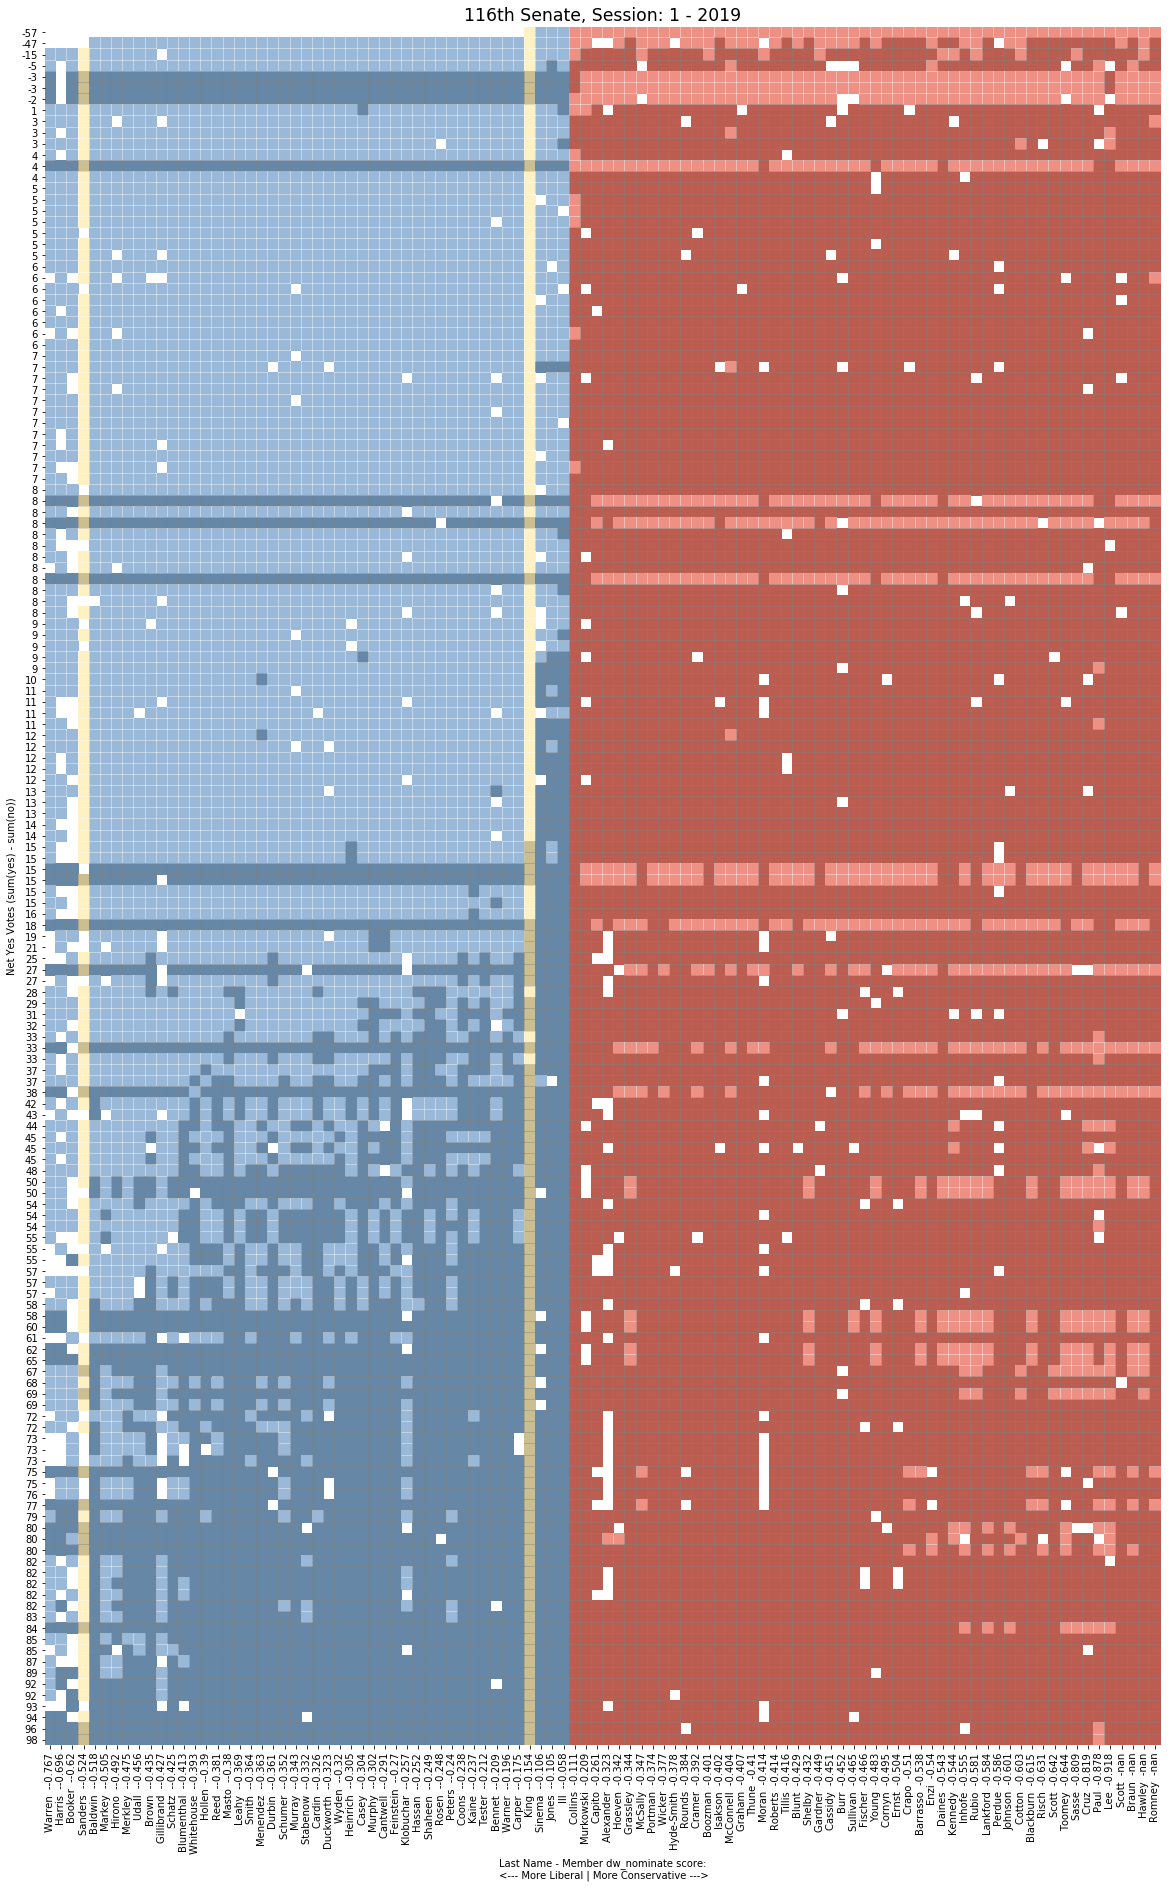

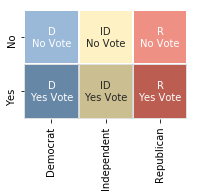

In [18]:
#Visualize a session
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def visualize_session(year, chamber):
    
    #Past versions of pandas have an error that prevents multiindex sorting with floats.
    assert int(''.join(pd.__version__.split('.'))) >= 242, 'Pandas should be version 0.24.2 or above'
    
    #load dataframe from csv or API
    _, df = load_cache(year, chamber)

    #set up a default dict that will return 1 if 'Yes,' -1 if 'No,' and 0 if anything else, while adding keys.
    factordict = defaultdict(int)
    factordict['Yes'], factordict['No'] = 1,-1

    #prep data (sort by party / dw_nominate score, then code yes / no into votes into negative positive values)
    data = df.applymap(lambda x: factordict[x]).sort_index('columns', 'dw_nominate')
    
    #sort by dw_nominate. (sort_index) doesn't work with floats... so.

    
    #sort votes by net votes
    sortseries = data.sum(axis=1)
    sortseries.sort_values(inplace=True)
    data = data.reindex(sortseries.index)
    mask = data.applymap(lambda x: x == 0).values

    #create a dataframe to map red and blue colors
    partydict = defaultdict(int)
    partydict['R'], partydict['D'] = 1, -1
    colormask = data.apply(lambda x: x.index.get_level_values(0).astype(str), axis=1, result_type='expand')
    colormask = colormask.applymap(lambda x: partydict[x])
    

    #change index's to something useful
    data.index = sortseries.values
    data.index.name = 'Net Yes Votes (sum(yes) - sum(no))'
    #newcol = data.columns.droplevel([level for level in data.columns.names if not level in ['dw_nominate', 'name']])    
    dw = data.columns.get_level_values('dw_nominate')
    lastnames = data.columns.get_level_values('name').map(lambda x: x.split(" ")[-1]+'  ')
    #print(lastnames)
    data.columns = pd.MultiIndex.from_arrays([lastnames, dw], names=('Last Name ',' Member dw_nominate score:\n <--- More Liberal | More Conservative --->'))
    #data.columns.name = 
    
    #setup scale
    base=10
    scale=1
    wd = 20
    ht = int(len(data.index)/scale+base)
    #print(wd, ht)
    f, ax = plt.subplots(1,1, figsize=(wd,ht))

    sns.set_palette('muted')

    #plot the party colors
    cmap = sns.color_palette('RdYlBu_r')
    sns.heatmap(data=colormask, ax=ax, cmap=cmap, linewidth=0, alpha=1, mask=mask, cbar=False, square=True)
    #cbar=True, cbar_kws = dict(use_gridspec=False, location='bottom'))

    #plot the yes no vote data
    cmap1 = ['white','grey']
    sns.heatmap(data=data, ax=ax, cmap=cmap1, linewidth=0, cbar=False, alpha=.4, mask=mask)
    
    #set up title (will need to modify to vizualize more than one session)
    titleitems = tuple(df.index.droplevel(3).tolist()[0])
    titlestring = '{}th {}, Session: {} - {}'.format(*titleitems,year)
    ax.set_title(titlestring, fontsize='xx-large')

    #display the "legend"
    display_key(cmap, cmap1)
    
    #display the p
    plt.show()

def display_key(cmap, cmap1):
    #Create the key
    f, ax1 = plt.subplots(1, figsize=(3, 2))

    labels = np.array([['D\nNo Vote','ID\nNo Vote','R\nNo Vote'],\
                   ['D\nYes Vote','ID\nYes Vote','R\nYes Vote']])

    xticklabels=['Democrat','Independent','Republican']
    yticklabels=['No','Yes']

    sns.heatmap(data=[[-1,0,1],[-1,0,1]], ax=ax1, cmap=cmap, linewidth=1, cbar=False, alpha=1, annot=labels, fmt='', square=True)
    sns.heatmap(data=[[-1,-1,-1],[1,1,1]], ax=ax1, cmap=cmap1, linewidth=1, cbar=False, alpha=.4, xticklabels=xticklabels, yticklabels=yticklabels)

    #show the plot

visualize_session(2019, 'Senate')


The plot above can be used to visualize all the votes in a given session, sorted by how many net votes they received, and the, and how liberal/conservative members are according to their dw_nominate score. 

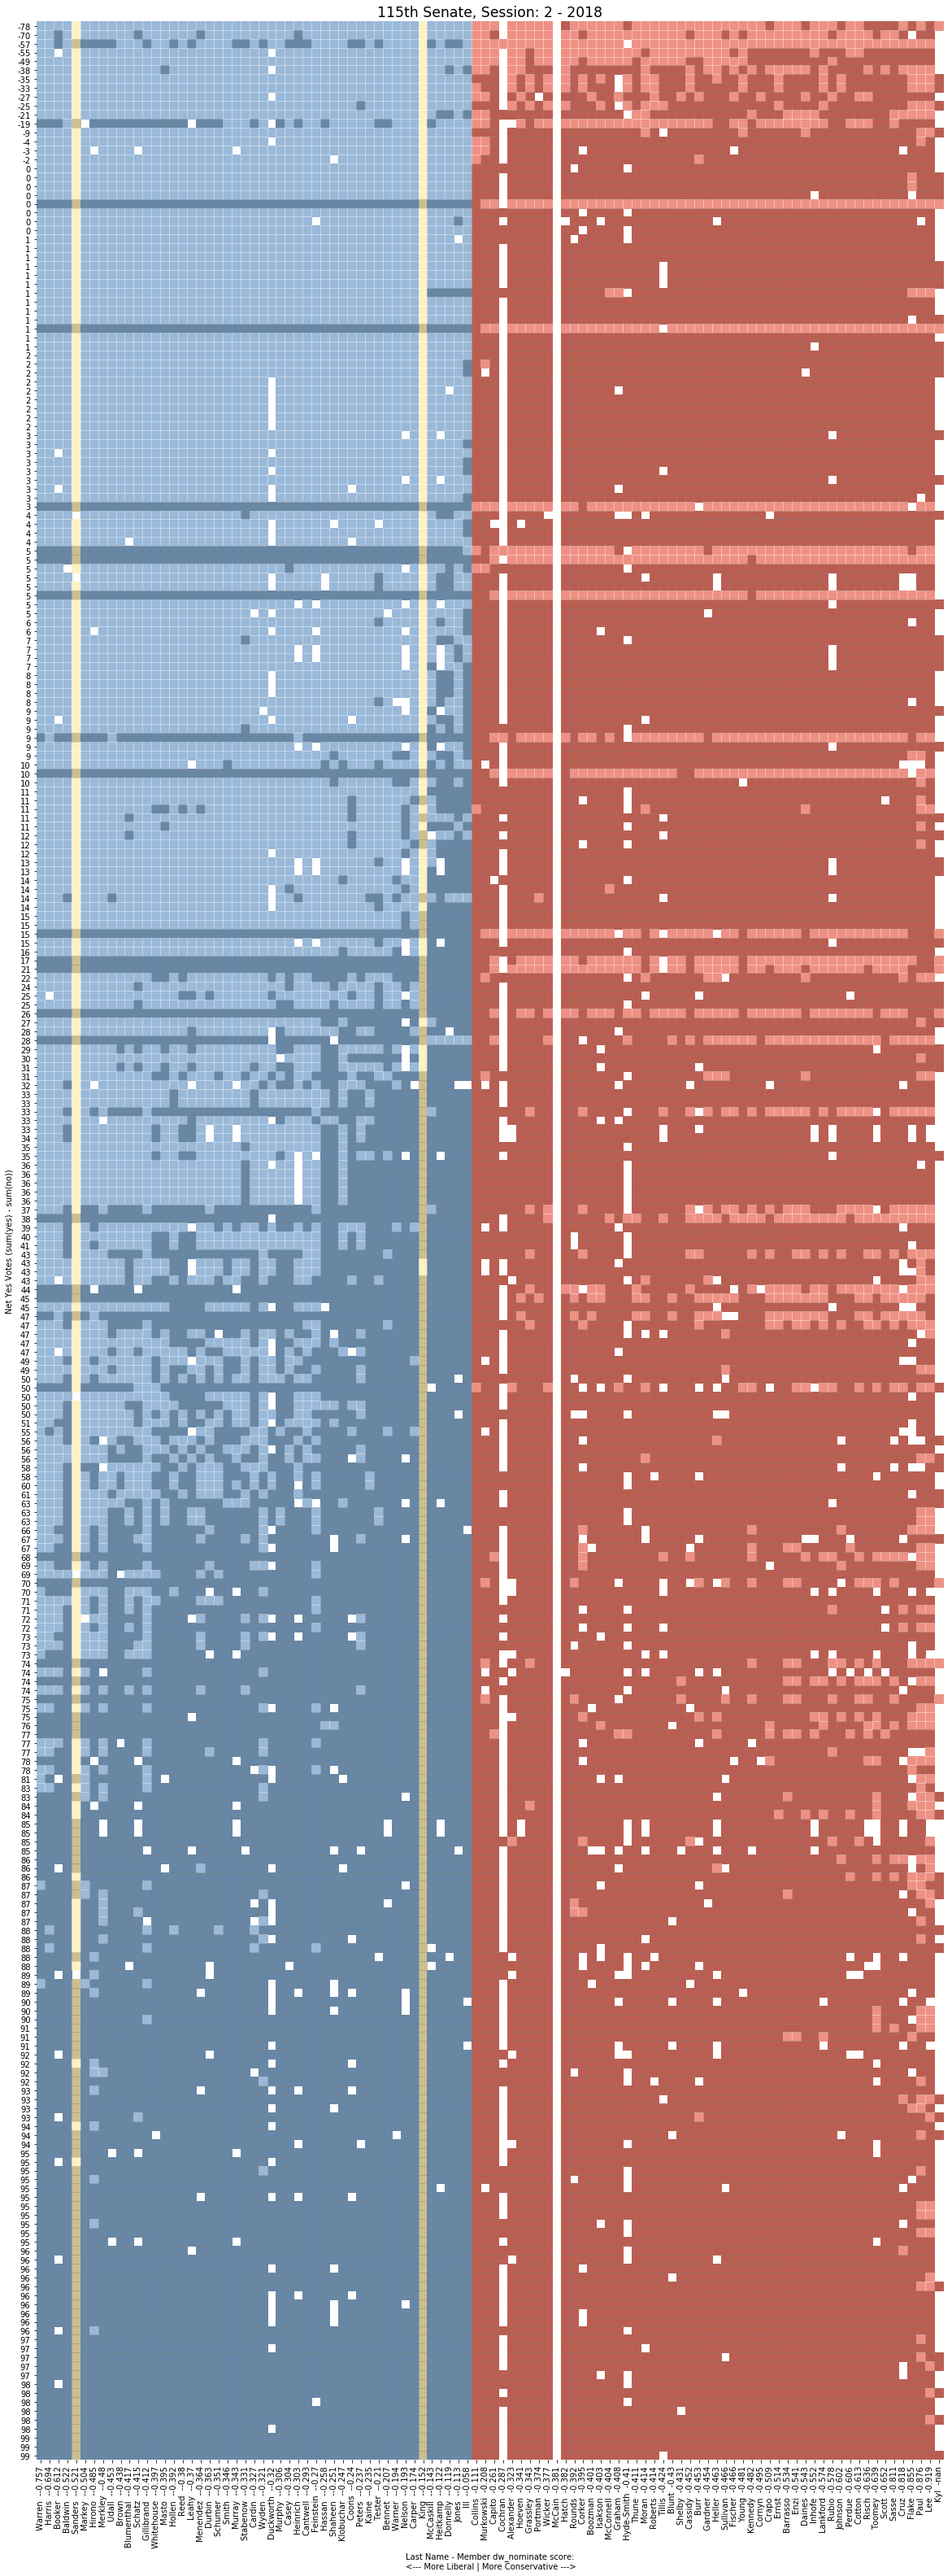

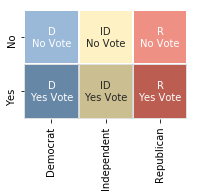

In [81]:
visualize_session(2018, 'Senate')

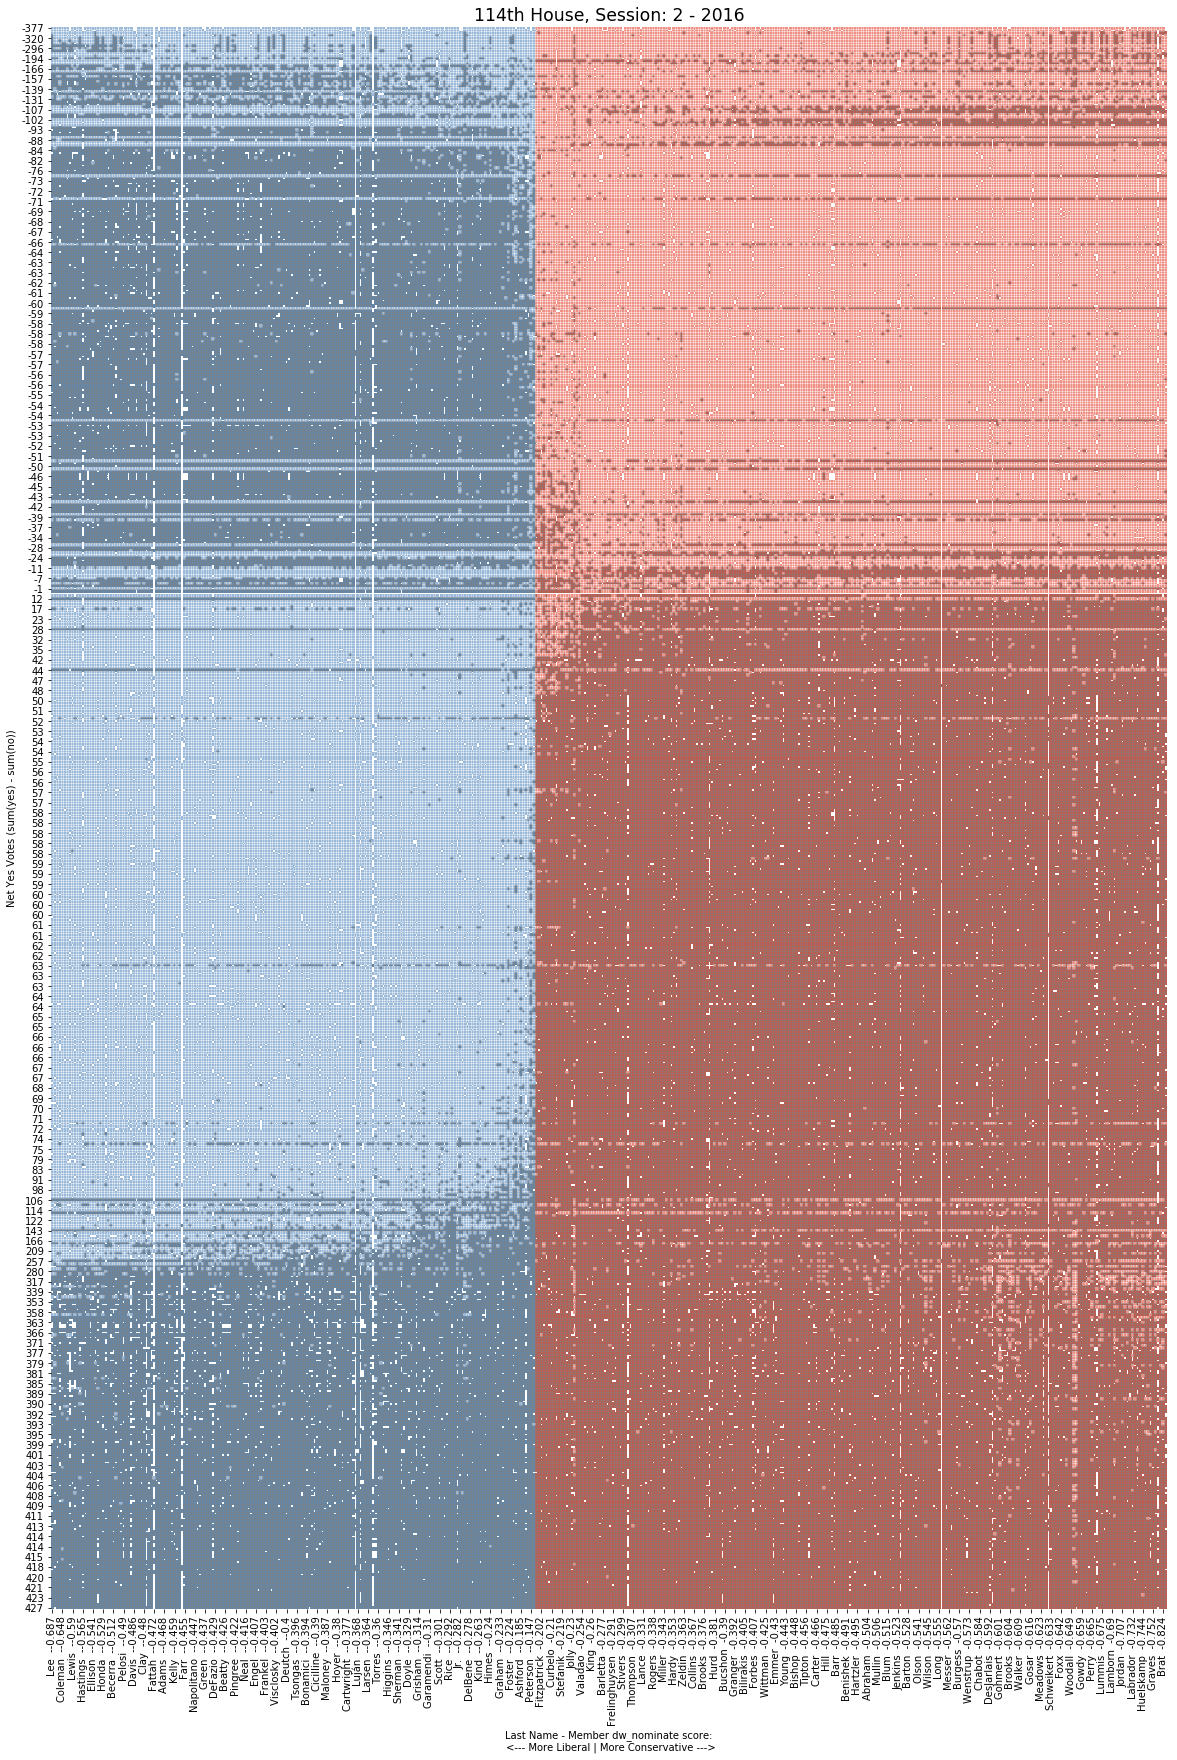

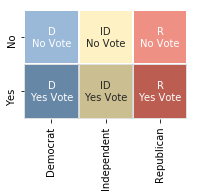

In [82]:
visualize_session(2016, 'house')

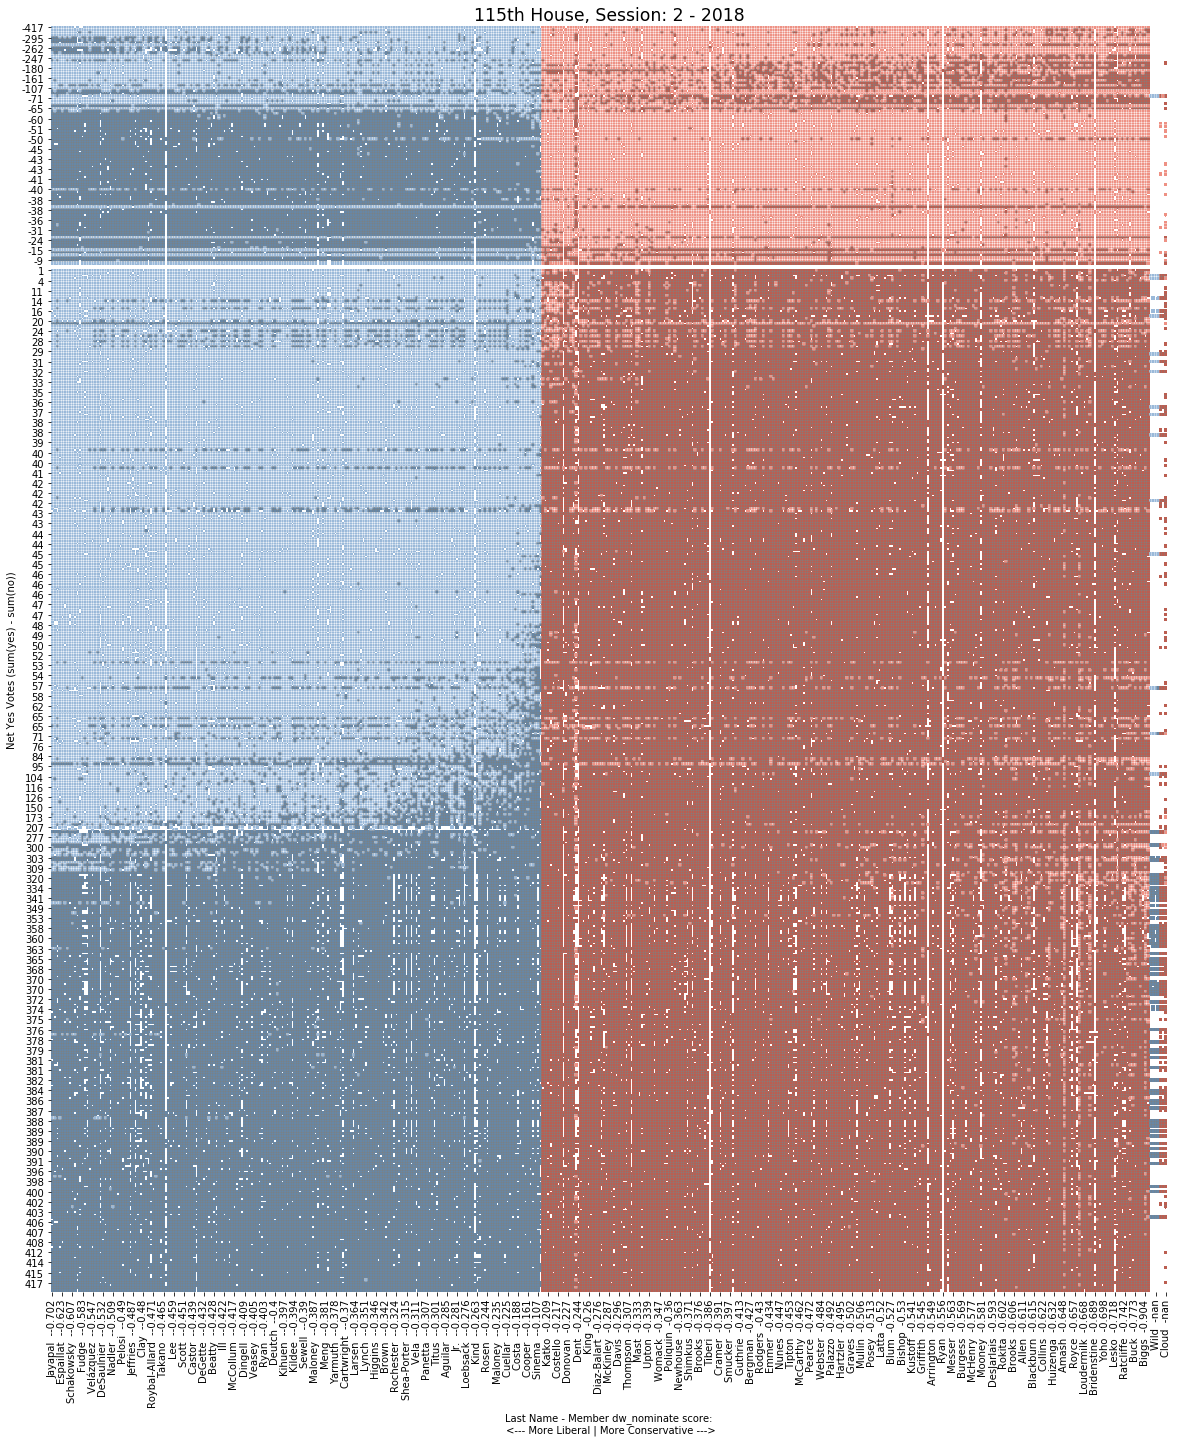

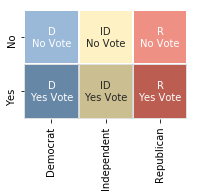

In [83]:
visualize_session(2018, 'House')

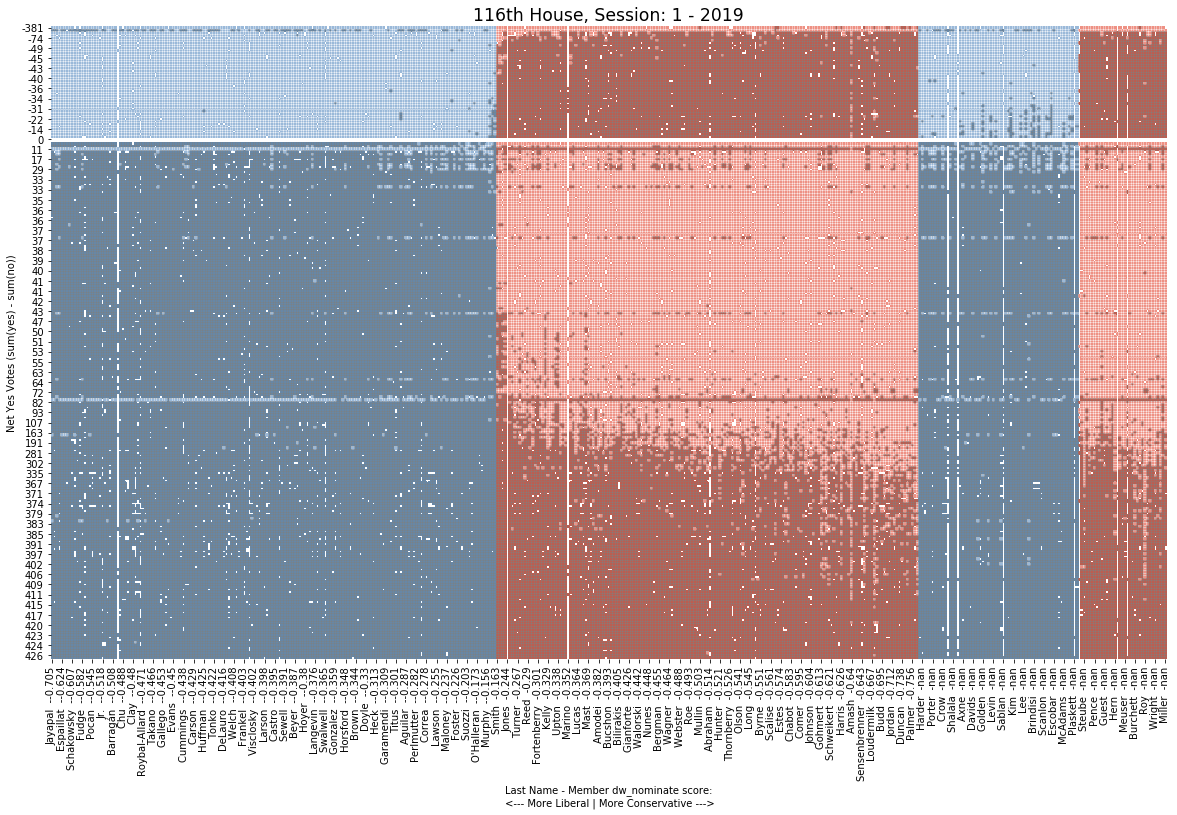

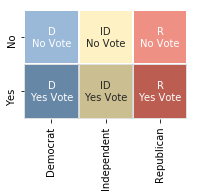

In [84]:
visualize_session(2019, 'house')

## Which members tend to survive?

In [6]:
meta, pos = load_cache(2019, 'Senate')
pos.columns.names

FrozenList(['party', 'state', 'dw_nominate', 'member_id', 'name'])

In [10]:
#Create list of longest surviving candidates - query api directly


#get a list of memebers for a (doesn't include start end years)
#for date in range(2010,2019,2):
#    meta, pos = load_cache(date, 'Senate')
#    print(meta.index[0])
#    congress, chamber = meta.index[0][:2]
#    print(congress, chamber)
#    members = import_members(congress, chamber)
#    print(members[0])
#    for member in members:
#        print(member['last_name'])

#create a df (set? dictionary?) of senators with their first start and last end date. 
#initialize dictionary
membersdict = {}
#for a range of dates
for date in range(1998,2019)[::2]:
    #load the meta and postions dataframes saved for that date
    meta, pos = load_cache(date, 'house')
    #extract the index.
    multi_index = pos.columns
    
    #loop through every item in the index
    for item in multi_index:
        #print(item)
        #make a dictionary out of the index items and keys
        indexdict = dict(zip(pos.columns.names, item))
        #print(indexdict)
        member_id = indexdict['member_id']
        if member_id not in membersdict.keys():
            m = get_member(member_id)
            r = m['roles']
            #print(m['first_name'],m['last_name'], end = ' ')
            #print(r[-1]['start_date'], r[0]['end_date'])
            mdict = {}
            for key in ['first_name', 'middle_name','last_name','current_party','in_office']:
                mdict[key] = m[key]
            mdict['start_date'] = r[-1]['start_date']
            mdict['end_date'] = r[0]['end_date']
            
            
            mdict.update(indexdict)
            membersdict[member_id] = mdict
            print('.', end='')
        
df = pd.DataFrame(membersdict)
df

#Different Critera... Seat changed party hands. 
#Seat was primaried.  

# Scatterplot v. district lean

#find where a member changed... and then query for the specific reason they left?

#shit... it should only be based on whether they were up for election... whether they were up for election is
#start date is their start date / end date. 

#votes with party percentage is something we can query. 

#dataframe... congress + start date end date of each.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,A000014,A000022,A000055,A000357,A000210,A000215,A000217,B000013,B000028,B000072,...,T000478,L000588,L000589,C001115,B001306,H001082,M001206,S001205,W000826,J000303
current_party,D,D,R,,D,,,R,,,...,R,D,R,R,R,R,D,D,D,D
district,1,5,4,1,1,7,26,6,6,6,...,22,18,8,27,12,1,25,7,15,13
dw_nominate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,-0.09,0.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,2010-02-28,2013-01-03,2021-01-03,2009-01-03,2014-02-18,2001-01-03,2003-01-03,2015-01-02,1999-01-03,2008-02-02,...,2019-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2019-01-03
first_name,Neil,Gary,Robert,Thomas,Robert,Bill,Richard,Spencer,Scotty,Richard,...,Claudia,Conor,Debbie,Michael,Troy,Kevin,Joe,Mary,Susan,Brenda
in_office,False,False,True,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,False
last_name,Abercrombie,Ackerman,Aderholt,Allen,Andrews,Archer,Armey,Bachus,Baesler,Baker,...,Tenney,Lamb,Lesko,Cloud,Balderson,Hern,Morelle,Scanlon,Wild,Jones
member_id,A000014,A000022,A000055,A000357,A000210,A000215,A000217,B000013,B000028,B000072,...,T000478,L000588,L000589,C001115,B001306,H001082,M001206,S001205,W000826,J000303
middle_name,None,L.,B.,H.,E.,None,K.,None,None,Hugh,...,None,None,None,None,None,None,None,Gay,None,
name,Neil Abercrombie,Gary L. Ackerman,Robert B. Aderholt,Thomas H. Allen,Robert E. Andrews,Bill Archer,Richard K. Armey,Spencer Bachus,Scotty Baesler,Richard Hugh Baker,...,Claudia Tenney,Conor Lamb,Debbie Lesko,Michael Cloud,Troy Balderson,Kevin Hern,Joe Morelle,Mary Gay Scanlon,Susan Wild,Brenda Jones


In [23]:
df = df.transpose()
df

,current_party,district,dw_nominate,end_date,first_name,in_office,last_name,member_id,middle_name,name,party,start_date,state,abs_nominate
A000014,D,1,NaN,2010-02-28 00:00:00,Neil,8562 days 00:00:00,Abercrombie,A000014,None,Neil Abercrombie,D,1986-09-20 00:00:00,HI,NaN
A000022,D,5,NaN,2013-01-03 00:00:00,Gary,10901 days 00:00:00,Ackerman,A000022,L.,Gary L. Ackerman,D,1983-03-01 00:00:00,NY,NaN
A000055,R,4,NaN,2021-01-03 00:00:00,Robert,8762 days 00:00:00,Aderholt,A000055,B.,Robert B. Aderholt,R,1997-01-07 00:00:00,AL,NaN
A000357,,1,NaN,2009-01-03 00:00:00,Thomas,4379 days 00:00:00,Allen,A000357,H.,Thomas H. Allen,D,1997-01-07 00:00:00,ME,NaN
A000210,D,1,NaN,2014-02-18 00:00:00,Robert,8447 days 00:00:00,Andrews,A000210,E.,Robert E. Andrews,D,1991-01-03 00:00:00,NJ,NaN
A000215,,7,NaN,2001-01-03 00:00:00,Bill,6575 days 00:00:00,Archer,A000215,None,Bill Archer,R,1983-01-03 00:00:00,TX,NaN
A000217,,26,NaN,2003-01-03 00:00:00,Richard,6574 days 00:00:00,Armey,A000217,K.,Richard K. Armey,R,1985-01-03 00:00:00,TX,NaN
B000013,R,6,NaN,2015-01-02 00:00:00,Spencer,8032 days 00:00:00,Bachus,B000013,None,Spencer Bachus,R,1993-01-05 00:00:00,AL,NaN
B000028,,6,NaN,1999-01-03 00:00:00,Scotty,2189 days 00:00:00,Baesler,B000028,None,Scotty Baesler,D,1993-01-05 00:00:00,KY,NaN
B000072,,6,NaN,2008-02-02 00:00:00,Richard,7697 days 00:00:00,Baker,B000072,Hugh,Richard Hugh Baker,R,1987-01-06 00:00:00,LA,NaN


In [24]:
len(df)

1077

In [25]:
df.loc[:,'start_date'] = pd.to_datetime(df.loc[:,'start_date'])

In [26]:
df.loc[:,'end_date'] = pd.to_datetime(df.loc[:,'end_date'])

In [27]:
df['in_office'] = (df.loc[:,'end_date'] - df.loc[:,'start_date'])
df

,current_party,district,dw_nominate,end_date,first_name,in_office,last_name,member_id,middle_name,name,party,start_date,state,abs_nominate
A000014,D,1,NaN,2010-02-28,Neil,8562 days,Abercrombie,A000014,None,Neil Abercrombie,D,1986-09-20,HI,NaN
A000022,D,5,NaN,2013-01-03,Gary,10901 days,Ackerman,A000022,L.,Gary L. Ackerman,D,1983-03-01,NY,NaN
A000055,R,4,NaN,2021-01-03,Robert,8762 days,Aderholt,A000055,B.,Robert B. Aderholt,R,1997-01-07,AL,NaN
A000357,,1,NaN,2009-01-03,Thomas,4379 days,Allen,A000357,H.,Thomas H. Allen,D,1997-01-07,ME,NaN
A000210,D,1,NaN,2014-02-18,Robert,8447 days,Andrews,A000210,E.,Robert E. Andrews,D,1991-01-03,NJ,NaN
A000215,,7,NaN,2001-01-03,Bill,6575 days,Archer,A000215,None,Bill Archer,R,1983-01-03,TX,NaN
A000217,,26,NaN,2003-01-03,Richard,6574 days,Armey,A000217,K.,Richard K. Armey,R,1985-01-03,TX,NaN
B000013,R,6,NaN,2015-01-02,Spencer,8032 days,Bachus,B000013,None,Spencer Bachus,R,1993-01-05,AL,NaN
B000028,,6,NaN,1999-01-03,Scotty,2189 days,Baesler,B000028,None,Scotty Baesler,D,1993-01-05,KY,NaN
B000072,,6,NaN,2008-02-02,Richard,7697 days,Baker,B000072,Hugh,Richard Hugh Baker,R,1987-01-06,LA,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1077 entries, A000014 to J000303
Data columns (total 14 columns):
current_party    1077 non-null object
district         1077 non-null object
dw_nominate      296 non-null object
end_date         1077 non-null datetime64[ns]
first_name       1077 non-null object
in_office        1077 non-null timedelta64[ns]
last_name        1077 non-null object
member_id        1077 non-null object
middle_name      350 non-null object
name             1077 non-null object
party            1077 non-null object
start_date       1077 non-null datetime64[ns]
state            1077 non-null object
abs_nominate     296 non-null object
dtypes: datetime64[ns](2), object(11), timedelta64[ns](1)
memory usage: 166.2+ KB


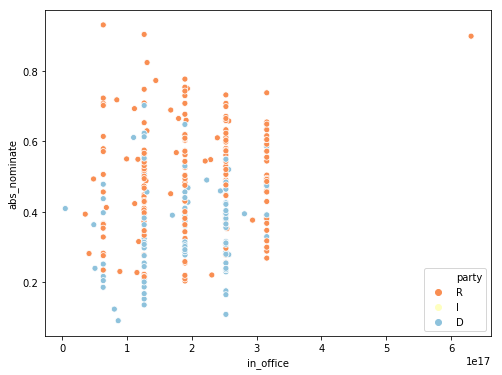

In [29]:

df['abs_nominate'] = abs(df.dw_nominate)
f, ax, = plt.subplots(1,1, figsize=(8,6))
palette = sns.color_palette('RdYlBu',3)
sns.scatterplot('in_office','abs_nominate','party', hue_order=['R','I','D'],
            data=df, ax=ax, palette=palette)
plt.show()